# Exercises 1, 2, 6, 7


## 1 

<img src="./images/01.png" alt="exercise1" height=40 width=700>

In [1]:
import torch
torch_tensor3d = torch.tensor([
                            [
                            [ 1, 2, 3],
                            [ 4, 5, 6],
                            ],
                            [
                            [ 7, 8, 9],
                            [10, 11, 12],
                            ],
                            [
                            [13, 14, 15],
                            [16, 17, 18],
                            ],
                            [
                            [19, 20, 21],
                            [22, 23, 24],
                            ]
                            ])


### Solution 1

In [2]:
dim = torch_tensor3d.shape
print(dim)
sum_torch_tensor3d = 0
for i in range(dim[0]):
    for j in range(dim[1]):
        for k in range(dim[2]):
            sum_torch_tensor3d += torch_tensor3d[i, j, k]

mean_torch_tensor3d = sum_torch_tensor3d / len(torch_tensor3d)
sum_torch_tensor3d, mean_torch_tensor3d

torch.Size([4, 2, 3])


(tensor(300), tensor(75.))

### Solution 2

In [3]:
dim = torch_tensor3d.shape
sum_torch_tensor3d = 0
for i in range(dim[0]):
    for j in range(dim[1]):
        for k in range(dim[2]):
            sum_torch_tensor3d += torch_tensor3d[i, j, k].item()

mean_torch_tensor3d = sum_torch_tensor3d / len(torch_tensor3d)
sum_torch_tensor3d, mean_torch_tensor3d

(300, 75.0)

## 2 

<img src="./images/02.png" alt="exercise1" height=40 width=700>

In [4]:
torch_tensor3d[2, 0, 0]

tensor(13)

# 6

<img src="./images/06.png" alt="exercise1" width=700>

**I couldn't download the specified dataset, so I decided to complete this exercise using a different dataset. I used the Mosquito-on-human-skin dataset, which is accessible [here](https://data.mendeley.com/datasets/zw4p9kj6nt/2). This dataset is structured as follows: it contains three main folders: Train, Test, and Pred. Each of these folders includes subfolders named according to the labels of the images they contain.**

<img src="./images/06_1.png" width=500>

#### None Lazy Approach

In [6]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


class TrainDtaset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.path = path
        self.paths = []
        self.labels =[]
        self.path_class = [pth_train for pth_train in self.path.rglob('*') if pth_train.is_dir()]
        self.folder_class = {path_cls.name: cls for cls, path_cls in enumerate(self.path_class)}
        for pth_class in self.path_class:
            for path_image in pth_class.rglob('*'):
                self.paths.append(path_image)
                self.labels.append(self.folder_class[pth_class.name])

    def __getitem__(self, index):

        image = Image.open(self.paths[index]).convert('RGB')
        transform = transforms.Compose(
                [   transforms.Resize((224, 224)),
                    transforms.ToTensor()
                ]
                )
        image_tensor = transform(image)
        label_tensor = torch.tensor(self.labels[index], dtype=torch.int64)
        return image_tensor, label_tensor

    def __len__(self):
        return len(self.paths)



In [10]:
from pathlib import Path
path = Path('./data_splitting/Test')
train_dataset = TrainDtaset(path)
print(len(train_dataset))
print(train_dataset[-1])

1799
(tensor([[[0.6549, 0.6588, 0.6549,  ..., 0.8157, 0.8118, 0.8118],
         [0.6471, 0.6510, 0.6510,  ..., 0.8196, 0.8196, 0.8196],
         [0.6510, 0.6510, 0.6471,  ..., 0.8157, 0.8157, 0.8157],
         ...,
         [0.6784, 0.6667, 0.6510,  ..., 0.7490, 0.7490, 0.7490],
         [0.6824, 0.6745, 0.6588,  ..., 0.7529, 0.7529, 0.7569],
         [0.6902, 0.6784, 0.6667,  ..., 0.7569, 0.7529, 0.7608]],

        [[0.5569, 0.5608, 0.5569,  ..., 0.7333, 0.7294, 0.7294],
         [0.5490, 0.5529, 0.5529,  ..., 0.7373, 0.7373, 0.7373],
         [0.5529, 0.5529, 0.5490,  ..., 0.7333, 0.7333, 0.7333],
         ...,
         [0.5569, 0.5451, 0.5294,  ..., 0.6510, 0.6510, 0.6510],
         [0.5569, 0.5490, 0.5294,  ..., 0.6510, 0.6510, 0.6549],
         [0.5647, 0.5529, 0.5373,  ..., 0.6549, 0.6510, 0.6588]],

        [[0.4784, 0.4824, 0.4784,  ..., 0.6667, 0.6627, 0.6627],
         [0.4706, 0.4745, 0.4745,  ..., 0.6706, 0.6706, 0.6706],
         [0.4667, 0.4667, 0.4627,  ..., 0.6667, 0.66

#### Lazy Approach
To make TrainDataset class use lazy loading in the __getitem__ method, we can modify it so that it doesn't load all the image paths and labels upfront in the __init__ method. Instead, we'll load the image names for each class only when they are needed during iteration. 

4200
torch.Size([3, 224, 224]) tensor(0)


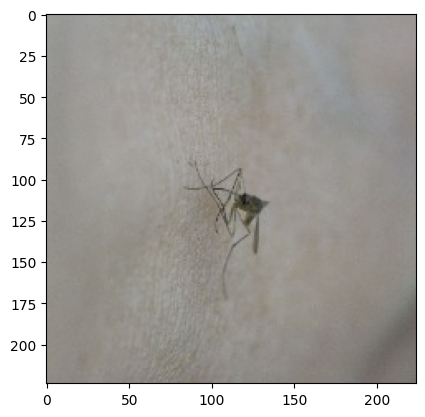

In [ ]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import bisect



class TrainDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.path = Path(path)
        self.class_folders = sorted([p for p in self.path.iterdir() if p.is_dir()])
        self.class_to_idx = {p.name: idx for idx, p in enumerate(self.class_folders)}
        self.class_image_counts = []
        self.class_cumulative_counts = []
        total_images = 0
        for class_folder in self.class_folders:
            # Count the number of images in each class without storing their paths
            class_image_count = len([1 for _ in class_folder.iterdir() if _.is_file()])
            self.class_image_counts.append(class_image_count)
            total_images += class_image_count
            self.class_cumulative_counts.append(total_images)
        self.total_images = total_images
        # Initialize a list to store image names per class, but load them lazily
        self.class_image_names = [None] * len(self.class_folders)

    def __len__(self):
        return self.total_images

    def __getitem__(self, index):
        # Determine which class the index belongs to
        class_idx = bisect.bisect_right(self.class_cumulative_counts, index)
        if class_idx == 0:
            image_idx_in_class = index
        else:
            image_idx_in_class = index - self.class_cumulative_counts[class_idx - 1]

        # Lazily load image names for the class if not already loaded
        if self.class_image_names[class_idx] is None:
            class_folder = self.class_folders[class_idx]
            image_names = sorted([p.name for p in class_folder.iterdir() if p.is_file()])
            self.class_image_names[class_idx] = image_names
        else:
            image_names = self.class_image_names[class_idx]

        image_name = image_names[image_idx_in_class]
        image_path = self.class_folders[class_idx] / image_name
        
        # Load and process the image
        image = Image.open(image_path).convert('RGB')
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        image_tensor = transform(image)
        label_tensor = torch.tensor(class_idx, dtype=torch.int64)
        return image_tensor, label_tensor


path = './data_splitting/Train'
dataset = TrainDataset(path)
print(len(dataset))
image_tensor, label_tensor = dataset[0]  # Load the first image and label
print(image_tensor.shape, label_tensor)
plt.imshow(image_tensor.permute(1, 2, 0))  # Permute to convert to (H, W, C) format for matplotlib


Explanation:
- Lazy Loading of Image Names:
  - In the __init__ method, we avoid loading all the image paths upfront. Instead, we initialize `self.class_image_names` as a list of None values.
  - In the __getitem__ method, we check if the image names for the required class have been loaded. If not, we load them and store them in `self.class_image_names`. This way, image names are loaded only when needed.

- Efficient Indexing:
  - We use the `bisect` module to efficiently determine the class index for a given dataset index.
  - By maintaining `self.class_cumulative_counts`, we can map any dataset index to the corresponding class and image index within that class.

- Avoiding Upfront Path Storage:
  - By not storing all image paths and labels upfront, we reduce memory usage and potentially speed up the dataset initialization, especially for large datasets.

This modification ensures that our dataset class now loads image paths lazily during iteration, which is especially useful when working with very large datasets.

## 7

<img src="./images/07.png" width=700>

**I have used Mosquito-on-human-skin instead of MNIST.**

- Step 1: Using NumPy's memmap functionality to write the Mosquito-on-human-skin dataset to disk.
- Step 2: Creating a MemmapedSimpleDataset that reads the mem-mapped files and generates PyTorch tensors in the __getitem__ method.
- Step 3: Explaining why this approach is useful.

### Step 1

In [71]:
import numpy as np
from pathlib import Path


def imge_to_memmap(path: Path, mem_image_name: str, mem_label_name: str)-> None:
    class_name_labels = {cls_dir.name: cls for cls, cls_dir in enumerate(path.glob('*')) if cls_dir.is_dir()}
    num_image = len([1 for _ in path.rglob('*') if _.is_file()])
    image_shape = (224, 224, 3)
    memmap_images = np.memmap(f'{mem_image_name}.dat', dtype="float32", mode="w+", shape=(num_image,)+image_shape)
    memmap_labels = np.memmap(f'{mem_label_name}.dat', dtype="int64", mode="w+", shape=(num_image,))
    for idx, image_path in enumerate(path.rglob('*.jpg')):
        label = class_name_labels[image_path.parent.name]
        img = Image.open(image_path).convert('RGB')
        img_array = np.array(img)
        memmap_images[idx] = img_array
        memmap_labels[idx] = label
        if idx % 500 == 0 and idx:
            print(f'{idx} images are processed')

    memmap_images.flush()
    memmap_labels.flush()
    del memmap_images
    del memmap_labels
    print(f'All images:{num_image} images are processed')
    print('Done')

In [72]:
path = Path('./data_splitting/Train')
imge_to_memmap(path, 'train_images', 'train_labels')

500 images are processed
1000 images are processed
1500 images are processed
2000 images are processed
2500 images are processed
3000 images are processed
3500 images are processed
4000 images are processed
All images:4200 images are processed
Done


### Step 2

4200
tensor(0)


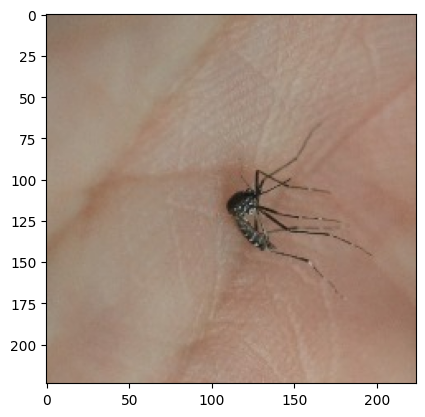

In [92]:
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision import transforms


class MemMosquitoDataset(Dataset):
    def __init__(self, mem_images, mem_labels):
        self.mem_labels = np.memmap(mem_labels, dtype=np.int64, mode='r')
        self.mem_images = np.memmap(mem_images, dtype=np.float32, mode='r', shape=(len(self.mem_labels), 224, 224, 3))
        # The np.memmap function creates a memory-mapped object. 
        # This object behaves like a NumPy array but accesses data directly from the file on disk.
    def __len__(self):
        return len(self.mem_labels)

    def __getitem__(self, idx):
        image = self.mem_images[idx] / 255
        label = self.mem_labels[idx]
        image = transforms.ToTensor()(image)
        label = torch.tensor(label, dtype=torch.int64)
        return image, label


train_dataset = MemMosquitoDataset('./train_images.dat', './train_labels.dat')
print(len(train_dataset))

# idx = 500
image_tensor, label_tensor = train_dataset[0]

print(label_tensor)
plt.imshow(image_tensor.permute(1, 2, 0))

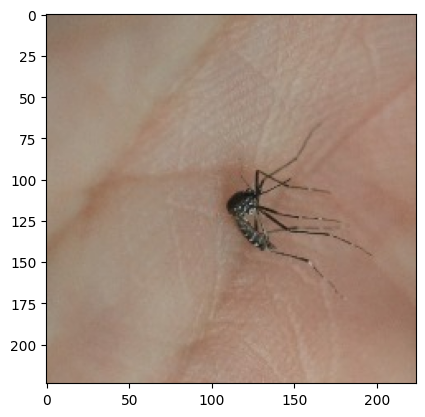

In [87]:
mem_images = np.memmap('./train_images.dat', dtype=np.float32, mode='r', shape=(4200, 224, 224, 3))
# print(mem_images[0])
plt.imshow(mem_images[0]/255)


### Step 3: Why Is This Useful?

#### Benefits of Using Mem-mapped Files

1. Memory Efficiency: Memory mapping allows you to work with datasets larger than your RAM. Data is loaded into memory only when needed and can be accessed in small chunks.

2. Fast Random Access: Since data is stored on disk in a binary format, you can access any part of the dataset quickly without loading the entire file into memory.

3. Low Memory Footprint: This approach minimizes the memory footprint of your program, as it avoids loading the entire dataset into memory.

#### Use Case Scenarios

- Large Datasets: When dealing with very large datasets (e.g., high-resolution images, long time-series data) that cannot fit into memory.

- Distributed Systems: In multi-processing or distributed training setups, mem-mapped files can be shared across processes with minimal overhead.

- Resource-Constrained Environments: Useful when working on machines with limited RAM but sufficient disk space.

#### Comparison with Standard Loading

- Standard Loading: Loading the entire dataset into memory can be impractical for large datasets, causing memory exhaustion.

- Mem-mapped Loading: Only the required data slices are loaded into memory during an iteration, making it scalable and efficient.